In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('data/cleaned_by_etienne.csv')


In [ ]:
# def get label_0(tree_in):
#     tree_in = tree_in.replace('["','').replace('"]','')
#     out =tree_in.split((' >> '))[0]
#     return out

In [ ]:
import re
def preprocess_text(sentence):
    sentence = unicodedata.normalize("NFKD",sentence)
    # # Remove punctuations and numbers
    # sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # # sentence.encode('latin-1')
    return sentence
df['description'] = df['description'].apply(preprocess_text)

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(df['description'].values).batch(128)
vectorizer.adapt(text_ds)
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'of',
 'for',
 'the',
 'and',
 'to',
 'in',
 'only',
 'with',
 'on',
 'at',
 'your',
 'products',
 'is',
 'free',
 'rs',
 'buy',
 'delivery',
 'shipping']

In [94]:
# si besoin de passer des stopwords il faudra les enlever de voc
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [80]:
import os
path_to_glove_file = "./glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [152]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,)

In [102]:
from tensorflow.keras import layers
nb_classes = 7
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(nb_classes, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         668400    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

In [124]:
from sklearn.model_selection import train_test_split

def get_subcateg(categ_tree, deepness = 0):
    subcateg = categ_tree.split(' >> ')[deepness]
    return subcateg


X = df['description'].values
X = vectorizer(X ).numpy()
df['categ_0'] = df["product_category_tree"].apply(get_subcateg, args=(0))
categ_0_list_num, categ_0_names= pd.factorize(df['categ_0'])

y = categ_0_list_num

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# x_train = vectorizer().numpy()
# x_val = vectorizer().numpy()

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128).repeat()
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(128).repeat()

In [128]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)

In [129]:
history = model.fit(ds_train,
                    epochs = 50,
                    validation_data=ds_val,
                    steps_per_epoch=64,
                    validation_steps = 8
                    )

Epoch 1/50
64/64 [==============================] - 6s 86ms/step - loss: 0.0068 - acc: 0.9981 - val_loss: 0.5568 - val_acc: 0.9143
Epoch 2/50
64/64 [==============================] - 5s 83ms/step - loss: 1.6492e-04 - acc: 1.0000 - val_loss: 0.6020 - val_acc: 0.9048
Epoch 3/50
64/64 [==============================] - 5s 83ms/step - loss: 5.4701e-05 - acc: 1.0000 - val_loss: 0.6152 - val_acc: 0.9048
Epoch 4/50
64/64 [==============================] - 5s 84ms/step - loss: 5.4774e-05 - acc: 1.0000 - val_loss: 0.6872 - val_acc: 0.9048
Epoch 5/50
64/64 [==============================] - 5s 83ms/step - loss: 6.7291e-05 - acc: 1.0000 - val_loss: 0.6271 - val_acc: 0.9238
Epoch 6/50
64/64 [==============================] - 5s 83ms/step - loss: 2.1273e-05 - acc: 1.0000 - val_loss: 0.6609 - val_acc: 0.9048
Epoch 7/50
64/64 [==============================] - 5s 81ms/step - loss: 2.2477e-05 - acc: 1.0000 - val_loss: 0.7134 - val_acc: 0.9048
Epoch 8/50
64/64 [==============================] - 5s 83ms

KeyboardInterrupt: 

In [33]:
# import unicodedata
# tutu = unicodedata.normalize("NFKD",tutu)

In [74]:
import sys
sys.getdefaultencoding()
.encode('latin-1')

'utf-8'

In [ ]:
# .encode('latin-1')

In [130]:
 model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         668400    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

In [132]:
from tensorflow.keras.models import Model
model_feature = Model(model.inputs, model.layers[-2].output)
model_feature.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         668400    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

In [140]:
text_sample, label_sample = next(iter(ds_train))

In [144]:
text_sample

<tf.Tensor: shape=(128, 200), dtype=int64, numpy=
array([[1823, 2554,  758, ...,    0,    0,    0],
       [  60,   32,    2, ...,    2,  111, 1312],
       [  60,   32,    2, ...,  127,   45,  135],
       ...,
       [  17, 2456, 4302, ...,    0,    0,    0],
       [  17,  979,  721, ...,    0,    0,    0],
       [  60,   32,    2, ...,    0,    0,    0]], dtype=int64)>

In [145]:
pred_all = model_feature.predict(X)


33/33 [==============================] - 1s 12ms/step


In [146]:
pred_all.shape

(1050, 128)

In [147]:
from sklearn.manifold import TSNE

In [148]:
tsne = TSNE(n_components = 2)
X_val_2D = tsne.fit_transform(pred_all)

c:\Users\fuetu\.virtualenvs\P23_marketplace-L_OXAFnN\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\fuetu\.virtualenvs\P23_marketplace-L_OXAFnN\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


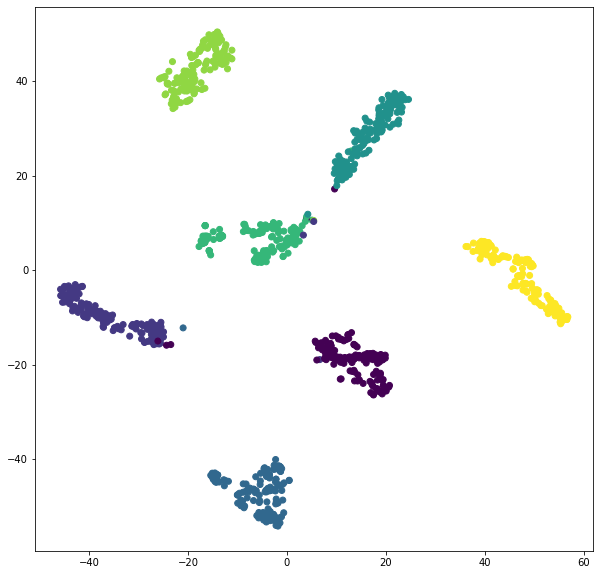

In [149]:
plt.figure(figsize=(10,10))
plt.scatter(X_val_2D[:,0], X_val_2D[:,1], c=pd.factorize(df['categ_0'])[0])